#### Assessing Marketplace Accessibility: Isochrones for Marketplaces and Supermarkets in Quezon City

Janssens & Sezer (2013). Marketplaces as an Urban Development Strategy (Editorial). Built Environment, 39: 10.2148/benv.39.2.169

Markets act as:
- commercial gathering places
- vivid & inclusive public spaces
- nexus of flows of people, goods, and information
- sources of: 
    - fresh & affordable food, 
    - economic opportunities, and 
    - chances to socialize
- engines for sustainable urban growth
- sites to get a pulse of a city
- domains of public discontent & dispute
- sites of congestion, chaos, illegality
- romantic images for late capitalist urban gentrification
- centers of social movements and grassroots initiatives

#### Where the Jobs Are: Analysis of Office Density in Metro Manila

##### Research Questions:
- What is the distribution of office buildings in Metro Manila?
- What are the dominant clusters of office space in Metro Manila?
- How much office space is there per city in Metro Manila?

##### Other indicators:
- Golf Courses (leisure facilities? green spaces?)
- Malls
- Educational (colleges & universities)
- Marketplaces
- LRT stations (isochrones)

Step 0: Set Up Workspace

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np

In [2]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

Step 1: Data Acquisition

To start, we will first extract all skyscrapers, or buildings which have 10 floors or higher. Unfortunately, the tags parameter in `osmnx.features_from_place()` can only have `str`s as values. 

To get around this, we will make use of list comprehension to quickly generate a list of numeric strs ranging from 10 floors to 100. 

A [quick search](https://en.wikipedia.org/wiki/List_of_tallest_structures_in_the_Philippines) will tell us that the actual highest number of floors for a building in the Philippines is 73, so our specified range is alright.

In [3]:
# Define place name as Metro Manila
PLACE_NAME = [
    "Metro Manila"
]

In [4]:
# Extract all skyscrapers in Metro Manila
skyscrapers = ox.features_from_place(
    PLACE_NAME,
    {
        "building:levels": [str(i) for i in range(30,100)]
    },
    which_result=None
)

In [5]:
type(skyscrapers)

geopandas.geodataframe.GeoDataFrame

Next, let us examine the data and see which information is most relevant. We can drop the columns and rows we don't need.

In [6]:
skyscrapers.head()

amenity  \
element_type osmid              
way          22788808     NaN   
             23394981     NaN   
             24547895     NaN   
             24547947     NaN   
             24547950     NaN   

                                                                geometry  \
element_type osmid                                                         
way          22788808  POLYGON ((121.02140 14.55751, 121.02152 14.557...   
             23394981  POLYGON ((121.07980 14.60738, 121.07965 14.607...   
             24547895  POLYGON ((121.03508 14.56457, 121.03504 14.564...   
             24547947  POLYGON ((121.03508 14.56529, 121.03488 14.565...   
             24547950  POLYGON ((121.03551 14.56572, 121.03551 14.565...   

                      wheelchair mapillary description addr:city  \
element_type osmid                                                 
way          22788808        NaN       NaN         NaN    Makati   
             23394981        NaN       NaN         NaN       NaN   
             24547895        NaN       NaN         NaN       NaN   
             24547947        NaN       NaN         NaN       NaN   
             24547950        NaN       NaN         NaN       NaN   

                      addr:postcode     addr:street              name  \
element_type osmid                                                      
way          22788808           NaN  Paseo de Roxas  Philamlife Tower   
             23394981           NaN             NaN         IBM Plaza   
             24547895           NaN             NaN       Rizal Tower   
             24547947           NaN             NaN      Luna Gardens   
             24547950           NaN             NaN     Amorsolo East   

                      operator  ... roof:orientation roof:colour developer  \
element_type osmid              ...                                          
way          22788808      NaN  ...              NaN         NaN       NaN   
             23394981      NaN  ...              NaN         NaN       NaN   
             24547895      NaN  ...              NaN         NaN       NaN   
             24547947      NaN  ...              NaN         NaN       NaN   
             24547950      NaN  ...              NaN         NaN       NaN   

                      proposed email building:units year_of_construction ways  \
element_type osmid                                                              
way          22788808      NaN   NaN            NaN                  NaN  NaN   
             23394981      NaN   NaN            NaN                  NaN  NaN   
             24547895      NaN   NaN            NaN                  NaN  NaN   
             24547947      NaN   NaN            NaN                  NaN  NaN   
             24547950      NaN   NaN            NaN                  NaN  NaN   

                      type addr:country  
element_type osmid                       
way          22788808  NaN          NaN  
             23394981  NaN          NaN  
             24547895  NaN          NaN  
             24547947  NaN          NaN  
             24547950  NaN          NaN  

[5 rows x 75 columns]

In [7]:
skyscrapers.shape

(793, 75)

In [8]:
skyscrapers.columns.values

array(['amenity', 'geometry', 'wheelchair', 'mapillary', 'description',
       'addr:city', 'addr:postcode', 'addr:street', 'name', 'operator',
       'brand', 'brand:wikidata', 'check_date', 'note', 'nodes',
       'addr:housenumber', 'building', 'building:levels', 'height',
       'postal_code', 'layer', 'wikidata', 'wikimedia_commons',
       'wikipedia', 'start_date', 'addr:housename', 'addr:street:corner',
       'building:part', 'addr:province', 'building:colour',
       'building:material', 'tourism', 'alt_name', 'official_name',
       'website', 'building:levels:underground', 'wikipedia:en',
       'name:en', 'old_name', 'construction', 'internet_access',
       'opening_hours', 'construction:building', 'previously', 'source',
       'fixme', 'phone', 'roof:levels', 'addr:quarter', 'architect',
       'name:zh-Hant', 'roof:shape', 'roof:material', 'addr2:street',
       'abandoned', 'owner', 'roof:height', 'building:min_level',
       'min_height', 'addr:place', 'smoking', 'co

In [9]:
skyscrapers.reset_index()["element_type"].unique()

array(['way', 'relation'], dtype=object)

In [10]:
from urban_indicators_scripts import filter_elem_type

skyscrapers = filter_elem_type(skyscrapers, ["way", "relation"])
skyscrapers.head()

,element_type,osmid,amenity,geometry,wheelchair,mapillary,description,addr:city,addr:postcode,addr:street,...,roof:orientation,roof:colour,developer,proposed,email,building:units,year_of_construction,ways,type,addr:country
0,way,22788808,NaN,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",NaN,NaN,NaN,Makati,NaN,Paseo de Roxas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,23394981,NaN,"POLYGON ((121.07980 14.60738, 121.07965 14.607...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,24547895,NaN,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,24547947,NaN,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,24547950,NaN,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
skyscrapers = drop_nan_cols(skyscrapers, 0.75)

In [12]:
skyscrapers.columns.values

array(['element_type', 'osmid', 'geometry', 'name', 'nodes', 'building',
       'building:levels', 'height', 'building:part'], dtype=object)

In [13]:
skyscrapers.isna().sum()

element_type         0
osmid                0
geometry             0
name               391
nodes                0
building           469
building:levels      0
height              95
building:part      323
dtype: int64

In [14]:
skyscrapers.head()

,element_type,osmid,geometry,name,nodes,building,building:levels,height,building:part
0,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Philamlife Tower,"[244891956, 244891957, 244891958, 244891959, 2...",commercial,48,200,NaN
1,way,23394981,"POLYGON ((121.07980 14.60738, 121.07965 14.607...",IBM Plaza,"[253295593, 253295592, 253295642, 1210079208, ...",yes,32,NaN,NaN
2,way,24547895,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",Rizal Tower,"[266905127, 2312911335, 2312911334, 2312911330...",apartments,47,161,NaN
3,way,24547947,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",Luna Gardens,"[266905163, 266905164, 266905165, 266905166, 2...",apartments,39,134.9,NaN
4,way,24547950,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",Amorsolo East,"[266905215, 266905216, 266905217, 266905218, 2...",residential,30,107,NaN


Let us plot the skyscrapers on a map to see what we have. But first, let's ensure that the CRS is pseudo-mercator for web-mapping.

In [15]:
epsg = skyscrapers.crs.to_epsg()

if epsg != 3857:
    print(f"GDF is in EPSG:{epsg} -- Will reproject to Pseudo-Mercator (EPSG:3857)")
    skyscrapers.to_crs("EPSG:3857", inplace=True)

GDF is in EPSG:4326 -- Will reproject to Pseudo-Mercator (EPSG:3857)


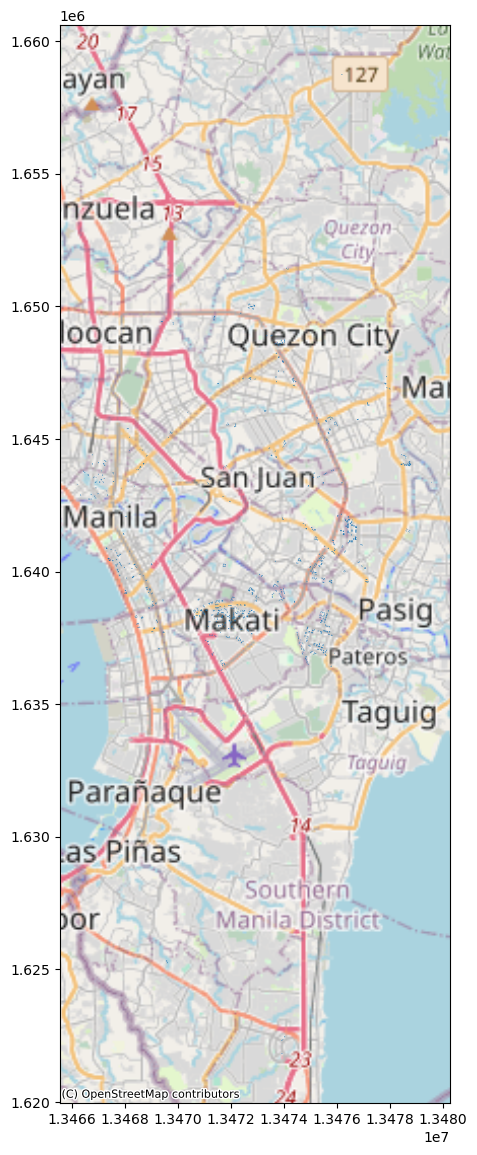

In [16]:
ax = skyscrapers.plot(
    figsize=(8,14),
    legend=True
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

In [17]:
# Get centroids
skyscrapers["centroid"] = skyscrapers.centroid

# Get coordinates of office points
coords = skyscrapers["centroid"].get_coordinates()
coords

,x,y
0,1.347208e+07,1.638247e+06
1,1.347856e+07,1.644022e+06
2,1.347357e+07,1.639043e+06
3,1.347356e+07,1.639128e+06
4,1.347362e+07,1.639180e+06
...,...,...
788,1.346972e+07,1.645247e+06
789,1.347151e+07,1.638638e+06
790,1.347551e+07,1.639718e+06
791,1.347309e+07,1.639898e+06


In [18]:
skyscrapers["x"] = coords.x
skyscrapers["y"] = coords.y

In [19]:
skyscrapers.dtypes

element_type         object
osmid                 int64
geometry           geometry
name                 object
nodes                object
building             object
building:levels      object
height               object
building:part        object
centroid           geometry
x                   float64
y                   float64
dtype: object

In [20]:
skyscrapers["area_sqm"] = skyscrapers["geometry"].area

skyscrapers["total_floor_area"] = skyscrapers["building:levels"].astype(int) * skyscrapers["area_sqm"]

In [ ]:
coords_wgs84 = (skyscrapers["centroid"]
    .to_crs("EPSG:4326")
    .get_coordinates()
)

coords_wgs84_list = [list(elem) for elem in zip(coords_wgs84.y, coords_wgs84.x)]
coords_wgs84_list

In [43]:
skyscrapers_wgs84 = skyscrapers.to_crs("EPSG:4326")
skyscrapers_wgs84["x"] = coords_wgs84.x
skyscrapers_wgs84["y"] = coords_wgs84.y

skyscrapers_wgs84["total_floor_area_log10"] = np.log10(skyscrapers_wgs84["total_floor_area"])

heatmap_list = skyscrapers_wgs84[["y", "x", "total_floor_area_log10"]].values.tolist()
heatmap_list

[[14.55742100010914, 121.02176545003628, 5.173329049920191],
 [14.60762955763829, 121.07994755457099, 4.83821951704538],
 [14.564346076735866, 121.03510499922444, 4.872816051076752],
 [14.565087133316531, 121.03508804899448, 4.641722922556755],
 [14.565531900079261, 121.03560280000025, 4.413442848372766],
 [14.548156981419849, 121.04509486554251, 4.910897016099997],
 [14.547364461528007, 121.04498923907991, 4.903362279486311],
 [14.545759610372333, 121.04538300614185, 4.692746394521227],
 [14.608606018443115, 121.08150707395022, 4.918697637700254],
 [14.633649728589832, 121.04246044644859, 5.051378130703324],
 [14.557605015690038, 121.0223661102839, 4.753319143231919],
 [14.589253131283979, 121.06061893715173, 4.789781332199602],
 [14.559959945477235, 121.0169430449165, 4.814627556767075],
 [14.559786408538423, 121.02558857507232, 4.793168062248397],
 [14.560853436506905, 121.01604332087332, 4.994218628488651],
 [14.559412187907991, 121.01161875954016, 4.78080547974196],
 [14.556561097

Testing whether folium.Heatmap does indeed take weights into account...

In [51]:
import folium
from folium.plugins import DualMap, HeatMap

m = DualMap(location=[14.585149, 121.034393], zoom_start=13)

HeatMap(heatmap_list, name="Weighted Heatmap", radius=20, blur=12).add_to(m.m1)
HeatMap(coords_wgs84_list, name="Unweighted Heatmap", radius=20, blur=12).add_to(m.m2)

folium.LayerControl(collapsed=False).add_to(m)

m

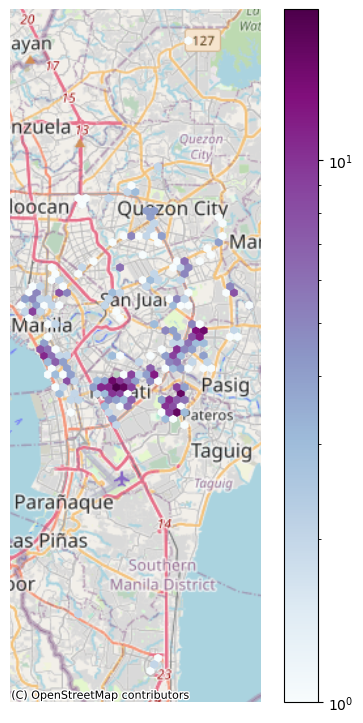

In [75]:
ax = skyscrapers.plot.hexbin(
    column="total_floor_area",
    x="x",
    y="y",

    figsize=(6,9),
    gridsize=(30,50),
    bins="log",
    reduce_C_function=np.sum,

    cmap="BuPu",
    # edgecolor="k",
    linewidth=0.3,
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

xmin = skyscrapers["x"].min()
xmax = skyscrapers["y"].max()

# ax.set_xlim(xmin, xmax)

In [ ]:
import matplotlib.ticker as ticker

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,14))

hb = ax2.hexbin(
    skyscrapers["x"],
    skyscrapers["y"],
    # C=skyscrapers["building:levels"].astype(int),
    C=skyscrapers["total_floor_area"],

    gridsize=(37,50),
    bins="log",
    # alpha=0.75,
    reduce_C_function=np.sum,

    cmap="BuPu",
    edgecolor="k",
    linewidth=0.3,

    mouseover=True,
    figure=fig
)

# ax2.set_xlim(1.3450,1.3490)

cb = fig.colorbar(
    hb, 
    ax=ax2, 
    label="Total Floor Area per Cell (in square meters)",
    format=ticker.LogFormatter(),
    aspect=50
)

plt.title(
    "Distribution of Skyscraper Floor Area\nin Metro Manila",
    fontsize="xx-large",
    horizontalalignment="center",
    fontweight="heavy"
)

cx.add_basemap(ax2, source=cx.providers.OpenStreetMap.Mapnik)